<a href="https://colab.research.google.com/github/roiei/ml_study/blob/master/%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-surprise


     |████████████████████████████████| 11.8 MB 45 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619429 sha256=16b4cc85888f364ca4be723a8f8f12ddf4283b3ae77b1ccfd5898457afab7643
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


## content-based filtering

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

In [ ]:
data = Dataset.load_builtin('ml-100k', prompt=False)
data.raw_ratings[:10]

Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


[('196', '242', 3.0, '881250949'),
 ('186', '302', 3.0, '891717742'),
 ('22', '377', 1.0, '878887116'),
 ('244', '51', 2.0, '880606923'),
 ('166', '346', 1.0, '886397596'),
 ('298', '474', 4.0, '884182806'),
 ('115', '265', 2.0, '881171488'),
 ('253', '465', 5.0, '891628467'),
 ('305', '451', 3.0, '886324817'),
 ('6', '86', 3.0, '883603013')]

In [ ]:
# (user, item, rating, id)

In [ ]:
model = SVD()

In [ ]:
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9309  0.9429  0.9353  0.9396  0.9394  0.9376  0.0041  
MAE (testset)     0.7350  0.7435  0.7349  0.7391  0.7417  0.7388  0.0035  
Fit time          4.91    4.72    4.81    5.09    5.07    4.92    0.14    
Test time         0.17    0.24    0.16    0.26    0.14    0.20    0.05    


{'fit_time': (4.9104485511779785,
  4.715155363082886,
  4.811928749084473,
  5.085328817367554,
  5.065017223358154),
 'test_mae': array([0.73499975, 0.74346667, 0.73485134, 0.73910972, 0.74172654]),
 'test_rmse': array([0.9308702 , 0.9428944 , 0.93532773, 0.93955265, 0.93941293]),
 'test_time': (0.1651465892791748,
  0.24354982376098633,
  0.1631484031677246,
  0.2646331787109375,
  0.1435871124267578)}

Content based filtering

쉬운 확장, 미관심 아이템 추천 가능
feature를 직접 설계 해야 함 - 기존 관심 사항을 가지고서만 추천 가능


In [ ]:
import numpy as np
from surprise import Dataset

In [ ]:
data = Dataset.load_builtin('ml-100k', prompt=False)

In [ ]:
raw_data = np.array(data.raw_ratings, dtype=int)

In [ ]:
raw_data

array([[      196,       242,         3, 881250949],
       [      186,       302,         3, 891717742],
       [       22,       377,         1, 878887116],
       ...,
       [      276,      1090,         1, 874795795],
       [       13,       225,         2, 882399156],
       [       12,       203,         3, 879959583]])

In [ ]:
raw_data[:, 0] -= 1
raw_data[:, 1] -= 1

In [ ]:
raw_data

array([[      195,       241,         3, 881250949],
       [      185,       301,         3, 891717742],
       [       21,       376,         1, 878887116],
       ...,
       [      275,      1089,         1, 874795795],
       [       12,       224,         2, 882399156],
       [       11,       202,         3, 879959583]])

In [ ]:
n_users = np.max(raw_data[:, 0])

In [ ]:
n_users

942

In [ ]:
n_movies = np.max(raw_data[:,1])

In [ ]:
shape = (n_users + 1, n_movies + 1)

In [ ]:
shape

(943, 1682)

In [ ]:
adj_matrix = np.ndarray(shape, dtype=int)

In [ ]:
for user_id, movie_id, rating, time in raw_data:
  adj_matrix[user_id][movie_id] = 1.
  

In [ ]:
adj_matrix

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [ ]:
my_id, my_vector = 0, adj_matrix[0]
best_match, best_match_id, best_match_vector = -1, -1, []

for user_id, user_vector in enumerate(adj_matrix):
  if my_id != user_id:
    similarity = np.dot(my_vector, user_vector)
    if similarity > best_match:
      best_match = similarity
      best_match_id = user_id
      best_match_vector = user_vector



In [ ]:
print('best match {}, best match id {}'.format(best_match, best_match_id))

best match 183, best match id 275


In [ ]:
print(my_vector)
print(best_match_vector)

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]


0번째 user와 가장 유사한 user는 275번 user

In [ ]:
recommend_list = []
for i, log in enumerate(zip(my_vector, best_match_vector)):
  log1, log2 = log
  if log1 == 0. and log2 == 1.:
    recommend_list += i,

In [ ]:
print(recommend_list)

[272, 273, 275, 280, 281, 283, 287, 288, 289, 290, 292, 293, 297, 299, 300, 301, 302, 306, 312, 314, 315, 316, 317, 321, 322, 323, 324, 327, 330, 331, 332, 333, 339, 342, 345, 346, 353, 354, 355, 356, 357, 363, 364, 365, 366, 372, 374, 378, 379, 381, 382, 383, 384, 385, 386, 387, 390, 391, 392, 394, 395, 396, 398, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 412, 414, 416, 417, 418, 419, 420, 422, 424, 425, 426, 427, 428, 430, 431, 432, 435, 442, 446, 447, 448, 449, 450, 451, 452, 454, 455, 457, 460, 461, 462, 468, 469, 470, 471, 472, 473, 474, 478, 495, 500, 507, 517, 522, 525, 530, 539, 540, 543, 545, 546, 548, 549, 550, 551, 553, 557, 558, 560, 561, 562, 563, 565, 566, 567, 568, 570, 571, 574, 575, 576, 577, 580, 581, 582, 585, 587, 589, 590, 594, 596, 602, 623, 626, 627, 630, 633, 635, 639, 646, 648, 651, 652, 654, 657, 664, 668, 671, 677, 678, 681, 683, 684, 685, 690, 691, 692, 695, 696, 708, 709, 714, 718, 719, 720, 724, 726, 727, 731, 733, 734, 736, 738, 741, 742, 745,

# 유클리드 거리로 추천
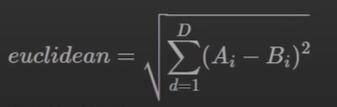
> 들여쓴 블록



sqrt(∑d=1~D (Ai - Bi)^2)

In [ ]:
def get_eclidean_dist(v1, v2):
  return -1*np.sqrt(np.sum(np.square(my_vector - user_vector)))

In [ ]:
def find_best_match_eclidean(my_id, my_vector):
  best_match, best_match_id, best_match_vector = float('inf'), -1, []

  for user_id, user_vector in enumerate(adj_matrix):
    if my_id != user_id:
      similarity = np.dot(my_vector, user_vector)
      eclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector)))
      if eclidean_dist < best_match:
        best_match = eclidean_dist
        best_match_id = user_id
        best_match_vector = user_vector

  return best_match, best_match_id, best_match_vector

In [ ]:
def find_best_match(my_id, my_vector, matrix, model_func):
  best_match, best_match_id, best_match_vector = float('-inf'), -1, []
  for user_id, user_vector in enumerate(matrix):
    if my_id != user_id:
      similarity = model_func(my_vector, user_vector)
      if similarity > best_match:
        best_match = similarity
        best_match_id = user_id
        best_match_vector = user_vector

  return best_match, best_match_id, best_match_vector

In [ ]:
est_match, best_match_id, best_match_vector = find_best_match(0, adj_matrix[0], get_eclidean_dist)


In [ ]:
print('best match {}, best match id {}'.format(best_match, best_match_id))

best match 14.832396974191326, best match id 737


In [ ]:
def get_recommend_list(my_vector, best_match_vector):
  recommend_list = []
  for i, log in enumerate(zip(my_vector, best_match_vector)):
    log1, log2 = log
    if log1 < 1. and log2 > 0.:
      recommend_list += i,

  return recommend_list

In [ ]:
print(recommend_list)

[297, 312, 317, 342, 356, 366, 379, 384, 392, 402, 404, 407, 417, 422, 428, 433, 448, 454, 469, 473, 495, 510, 516, 526, 527, 549, 567, 602, 635, 649, 650, 654, 658, 661, 664, 696, 731, 746, 750, 754, 915, 918, 925, 929, 950, 968, 1015, 1046]


# Cosine similarity

In [ ]:
def compute_cos_sim(v1, v2):
  norm1 = np.sqrt(np.sum(np.square(v1)))
  norm2 = np.sqrt(np.sum(np.square(v2)))
  dot = np.dot(v1, v2)
  return dot / (norm1*norm2)



In [ ]:
best_match, best_match_id, best_match_vector = find_best_match(0, adj_matrix[0], adj_matrix, compute_cos_sim)

In [ ]:
print('best match {}, best match id {}'.format(best_match, best_match_id))

best match 0.569065731527988, best match id 915


In [ ]:
recommend_list = get_recommend_list(my_vector, best_match_vector)

NameError: ignored

In [ ]:
print(recommend_list)

[272, 275, 279, 280, 283, 285, 289, 294, 297, 316, 317, 355, 365, 366, 368, 379, 380, 381, 384, 386, 392, 398, 401, 404, 416, 420, 422, 424, 426, 427, 430, 432, 450, 460, 461, 466, 469, 471, 473, 474, 475, 479, 482, 483, 497, 505, 508, 510, 511, 522, 526, 527, 529, 530, 534, 536, 540, 545, 548, 549, 556, 557, 558, 560, 565, 567, 568, 569, 577, 580, 581, 582, 592, 596, 630, 635, 639, 641, 649, 651, 654, 673, 677, 678, 683, 684, 692, 696, 701, 703, 707, 708, 709, 712, 714, 719, 720, 726, 731, 734, 736, 738, 740, 745, 747, 754, 755, 761, 762, 763, 766, 780, 789, 791, 805, 819, 823, 824, 830, 843, 862, 865, 918, 929, 930, 938, 942, 943, 947, 958, 959, 960, 970, 977, 1004, 1008, 1009, 1010, 1013, 1041, 1045, 1069, 1072, 1073, 1078, 1097, 1100, 1108, 1112, 1118, 1134, 1193, 1205, 1207, 1216, 1219, 1267, 1334, 1400, 1427, 1596, 1681]


## 기존 방법에 명시적 feedback 추가

In [ ]:
adj_matrix = np.ndarray(shape, dtype=int)
for user_id, movie_id, rating, time in raw_data:
  adj_matrix[user_id][movie_id] = rating

In [ ]:
adj_matrix

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]])

In [ ]:
best_match, best_match_id, best_match_vector = find_best_match_eclidean(0, adj_matrix[0])

In [ ]:
print('best match {}, best match id {}'.format(best_match, best_match_id))

best match 55.06359959174482, best match id 737


In [ ]:
best_match, best_match_id, best_match_vector = find_best_match(0, adj_matrix[0], compute_cos_sim)
print('best match {}, best match id {}'.format(best_match, best_match_id))

best match 0.569065731527988, best match id 915


# collaborative filtering

기존 관심이 아닌 것의 추천이 가능함
feature를 알 필요가 없음

cold-latency가 있음
추가 특성 사용이 어려움 

In [ ]:
from surprise import KNNBasic, SVD, SVDpp, NMF
from surprise import Dataset
from surprise.model_selection import cross_validate

In [ ]:
data = Dataset.load_builtin('ml-100k', prompt=False)

## collaborative filtering with KNN (Nearest Neighbor)

In [ ]:
model = KNNBasic()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9843  0.9809  0.9776  0.9751  0.9781  0.9792  0.0031  
MAE (testset)     0.7749  0.7761  0.7710  0.7697  0.7738  0.7731  0.0024  
Fit time          0.42    1.03    0.54    0.95    0.59    0.71    0.24    
Test time         6.60    9.35    8.28    6.68    4.44    7.07    1.67    


{'fit_time': (0.422623872756958,
  1.0282177925109863,
  0.544945478439331,
  0.9493236541748047,
  0.592808723449707),
 'test_mae': array([0.77487979, 0.77608821, 0.77101561, 0.76972097, 0.77375284]),
 'test_rmse': array([0.98430446, 0.98085017, 0.97760271, 0.97514126, 0.97806215]),
 'test_time': (6.599138021469116,
  9.349785089492798,
  8.28296971321106,
  6.675295829772949,
  4.437984228134155)}

## collaborative filtering with SVD

In [ ]:
model = SVD()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9374  0.9357  0.9378  0.9376  0.9336  0.9364  0.0016  
MAE (testset)     0.7399  0.7414  0.7377  0.7388  0.7340  0.7384  0.0025  
Fit time          11.50   15.13   15.39   12.76   8.89    12.73   2.41    
Test time         0.70    0.57    0.49    0.28    0.17    0.44    0.20    


{'fit_time': (11.503535509109497,
  15.132008075714111,
  15.391123533248901,
  12.759834289550781,
  8.886595487594604),
 'test_mae': array([0.73994769, 0.74139153, 0.7376755 , 0.73884946, 0.73396998]),
 'test_rmse': array([0.93742088, 0.93566368, 0.93783935, 0.93756692, 0.93361914]),
 'test_time': (0.7045497894287109,
  0.5651793479919434,
  0.49170994758605957,
  0.27554941177368164,
  0.16616201400756836)}

## collaborative filtering with NMF (Non negative Matrix Factorization)

In [ ]:
model = NMF()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9580  0.9685  0.9531  0.9724  0.9667  0.9637  0.0071  
MAE (testset)     0.7553  0.7606  0.7493  0.7637  0.7592  0.7576  0.0049  
Fit time          12.48   16.32   17.43   13.86   9.79    13.97   2.73    
Test time         0.75    0.56    0.29    0.24    0.17    0.40    0.22    


{'fit_time': (12.481255054473877,
  16.320284128189087,
  17.426214933395386,
  13.859009742736816,
  9.78527545928955),
 'test_mae': array([0.75527228, 0.76057648, 0.74934184, 0.76369895, 0.75919401]),
 'test_rmse': array([0.95797852, 0.96847057, 0.9530902 , 0.97244727, 0.96665278]),
 'test_time': (0.7520012855529785,
  0.560783863067627,
  0.2872915267944336,
  0.2367994785308838,
  0.16922783851623535)}

## collaborative filtering with SVD++

In [ ]:
model = SVDpp()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9224  0.9120  0.9150  0.9183  0.9272  0.9190  0.0054  
MAE (testset)     0.7233  0.7167  0.7193  0.7203  0.7256  0.7210  0.0031  
Fit time          659.80  676.91  674.23  664.90  177.31  570.63  196.76  
Test time         13.12   12.29   11.32   12.49   3.45    10.54   3.59    


{'fit_time': (659.7962131500244,
  676.9084165096283,
  674.2303149700165,
  664.9017832279205,
  177.30719876289368),
 'test_mae': array([0.72333719, 0.71668345, 0.71928763, 0.72027156, 0.72562894]),
 'test_rmse': array([0.92238062, 0.91198948, 0.91497139, 0.9182806 , 0.92716417]),
 'test_time': (13.124354124069214,
  12.292790412902832,
  11.321568727493286,
  12.492684125900269,
  3.452782154083252)}

# Hybrid

많은 방법 이 존재함
여기서는

1. collaborative filtering으로 embedding을 학습 
2. content-based filtering으로 유사도 기반 추천 수행

In [ ]:
import numpy as np
from sklearn.decomposition import randomized_svd, non_negative_factorization
from surprise import Dataset

In [ ]:
data = Dataset.load_builtin('ml-100k', prompt=False)
raw_data = np.array(data.raw_ratings, dtype=int)
raw_data[:, 0] -= 1
raw_data[:, 1] -= 1

Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [ ]:
n_users = np.max(raw_data[:, 0])
n_movies = np.max(raw_data[:, 1])
share = (n_users + 1, n_movies + 1)

In [ ]:
shape

NameError: ignored

In [ ]:
adj_matrix = np.ndarray(share, dtype=int)

In [ ]:
for user_id, movie_id, rating, time in raw_data:
  adj_matrix[user_id][movie_id] = rating
  

In [ ]:
adj_matrix

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]])

In [ ]:
# U: user
# V: item
# S: singular vector
U, S, V = randomized_svd(adj_matrix, n_components=2)

In [ ]:
S = np.diag(S)

In [ ]:
print(U.shape, S.shape, V.shape)

(943, 2) (2, 2) (2, 1682)


S는 latent factor에 대한 특잇값 행렬

In [ ]:
np.matmul(np.matmul(U, S), V)

array([[ 3.91732663e+00,  1.47276644e+00,  7.98261988e-01, ...,
         6.24907189e-04,  1.41100852e-02,  1.36545878e-02],
       [ 1.85777226e+00,  3.96191175e-01,  5.05705740e-01, ...,
         5.38862978e-03,  1.77237914e-03,  5.26968095e-04],
       [ 8.94989517e-01,  1.71578497e-01,  2.51738682e-01, ...,
         2.92094923e-03,  5.39937171e-04, -1.25733753e-04],
       ...,
       [ 9.92051955e-01,  2.10814957e-01,  2.70363365e-01, ...,
         2.89019297e-03,  9.34221962e-04,  2.66612193e-04],
       [ 1.30425401e+00,  5.27669941e-01,  2.50080165e-01, ...,
        -4.20677765e-04,  5.30525683e-03,  5.28069948e-03],
       [ 2.82999397e+00,  9.70812247e-01,  6.15871694e-01, ...,
         2.02091492e-03,  8.67740813e-03,  8.03107892e-03]])

In [ ]:
best_match, best_match_id, best_match_vector = find_best_match(0, U[0], U, compute_cos_sim)

## 사용자 기반 추천

In [ ]:
print('best match {}, best match id {}'.format(best_match, best_match_id))

best match 0.9999942295956324, best match id 235


SVD -> cosine sim의 경우 96%
즉, latent factor model의 성능이 좋음을 알 수 있음

In [ ]:
recommend_list = get_recommend_list(adj_matrix[0], adj_matrix[best_match_id])

In [ ]:
print(recommend_list)

[272, 273, 274, 281, 285, 288, 293, 297, 303, 306, 312, 317, 327, 332, 369, 410, 418, 419, 422, 426, 428, 431, 434, 442, 461, 475, 477, 482, 495, 503, 504, 505, 506, 509, 519, 520, 522, 525, 531, 545, 548, 590, 594, 595, 613, 631, 654, 658, 660, 672, 684, 685, 691, 695, 698, 704, 716, 728, 734, 749, 755, 863, 865, 933, 1012, 1038, 1101, 1327, 1400]


##  항목 기반 추천


앞서 U(즉, user), 여기서는 item인 V를 사용
V는 transpose 필요

In [ ]:
best_match, best_match_id, best_match_vector = find_best_match(0, V.T[0], V.T, compute_cos_sim)

In [ ]:
print('best match {}, best match id {}'.format(best_match, best_match_id))

best match 0.9999999951364145, best match id 1287


In [ ]:
def get_recommend_list_lfm(matrix, my_id):
  recommend_list = []
  for i, user_vector in enumerate(matrix):
    if adj_matrix[i][my_id] > 0.9:
      recommend_list += i,

  return recommend_list


In [ ]:
print(get_recommend_list_lfm(adj_matrix, 0))

[0, 1, 4, 5, 9, 12, 14, 15, 16, 17, 19, 20, 22, 24, 25, 37, 40, 41, 42, 43, 44, 48, 53, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 69, 71, 72, 74, 76, 78, 80, 81, 82, 83, 88, 91, 92, 93, 94, 95, 96, 98, 100, 101, 105, 107, 108, 116, 119, 120, 123, 124, 127, 129, 130, 133, 136, 137, 140, 143, 144, 147, 149, 150, 156, 157, 159, 161, 167, 173, 176, 177, 180, 181, 183, 188, 192, 193, 197, 198, 199, 200, 201, 202, 203, 208, 209, 212, 215, 221, 222, 229, 230, 231, 233, 234, 241, 242, 243, 245, 246, 247, 248, 249, 250, 251, 252, 253, 255, 261, 262, 264, 267, 270, 273, 274, 275, 276, 278, 279, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 300, 302, 304, 306, 307, 310, 311, 312, 313, 319, 321, 323, 324, 325, 326, 329, 330, 331, 335, 337, 338, 339, 342, 343, 344, 346, 347, 349, 356, 358, 359, 362, 364, 370, 373, 377, 378, 379, 380, 386, 387, 388, 389, 392, 393, 394, 395, 397, 398, 400, 401, 402, 405, 406, 410, 411, 415, 416, 418, 421, 423, 424, 428, 431, 433, 434, 437, 440, 444, 

## 비음수 행렬 분해를 사용한 hybrid 추천

In [ ]:
adj_matrix

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]])

In [ ]:
A, B, iter = non_negative_factorization(adj_matrix, n_components=2)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1035: FutureWarning: The default value of init will change from random to None in 0.23 to make it consistent with decomposition.NMF.
  "with decomposition.NMF.", FutureWarning)


In [ ]:
np.matmul(A, B)

array([[3.71104575e+00, 1.48477418e+00, 7.39554024e-01, ...,
        3.64524635e-03, 1.45528284e-02, 1.44126854e-02],
       [2.11740262e+00, 2.36758375e-01, 5.51611538e-01, ...,
        4.76689390e-03, 2.46533278e-05, 0.00000000e+00],
       [9.85430825e-01, 1.10186414e-01, 2.56717834e-01, ...,
        2.21849362e-03, 1.14735615e-05, 0.00000000e+00],
       ...,
       [1.04463613e+00, 1.16806483e-01, 2.72141603e-01, ...,
        2.35178211e-03, 1.21629003e-05, 0.00000000e+00],
       [1.45790352e+00, 5.42099426e-01, 2.99288597e-01, ...,
        1.61342606e-03, 5.15834843e-03, 5.10702576e-03],
       [2.44663560e+00, 9.41419347e-01, 4.95534900e-01, ...,
        2.56819760e-03, 9.08627080e-03, 8.99727174e-03]])

In [ ]:
best_match, best_match_id, best_match_vector = find_best_match(0, U[0], U, compute_cos_sim)
print('best match {}, best match id {}'.format(best_match, best_match_id))

best match 0.9999942295956324, best match id 235


In [ ]:
print(get_recommend_list_lfm(adj_matrix, 0))

[0, 1, 4, 5, 9, 12, 14, 15, 16, 17, 19, 20, 22, 24, 25, 37, 40, 41, 42, 43, 44, 48, 53, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 69, 71, 72, 74, 76, 78, 80, 81, 82, 83, 88, 91, 92, 93, 94, 95, 96, 98, 100, 101, 105, 107, 108, 116, 119, 120, 123, 124, 127, 129, 130, 133, 136, 137, 140, 143, 144, 147, 149, 150, 156, 157, 159, 161, 167, 173, 176, 177, 180, 181, 183, 188, 192, 193, 197, 198, 199, 200, 201, 202, 203, 208, 209, 212, 215, 221, 222, 229, 230, 231, 233, 234, 241, 242, 243, 245, 246, 247, 248, 249, 250, 251, 252, 253, 255, 261, 262, 264, 267, 270, 273, 274, 275, 276, 278, 279, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 300, 302, 304, 306, 307, 310, 311, 312, 313, 319, 321, 323, 324, 325, 326, 329, 330, 331, 335, 337, 338, 339, 342, 343, 344, 346, 347, 349, 356, 358, 359, 362, 364, 370, 373, 377, 378, 379, 380, 386, 387, 388, 389, 392, 393, 394, 395, 397, 398, 400, 401, 402, 405, 406, 410, 411, 415, 416, 418, 421, 423, 424, 428, 431, 433, 434, 437, 440, 444, 

In [ ]:
best_match, best_match_id, best_match_vector = find_best_match(0, V.T[0], V.T, compute_cos_sim)
print('best match {}, best match id {}'.format(best_match, best_match_id))

best match 0.9999999951364145, best match id 1287


In [ ]:
print(get_recommend_list_lfm(adj_matrix, 0))

[0, 1, 4, 5, 9, 12, 14, 15, 16, 17, 19, 20, 22, 24, 25, 37, 40, 41, 42, 43, 44, 48, 53, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 69, 71, 72, 74, 76, 78, 80, 81, 82, 83, 88, 91, 92, 93, 94, 95, 96, 98, 100, 101, 105, 107, 108, 116, 119, 120, 123, 124, 127, 129, 130, 133, 136, 137, 140, 143, 144, 147, 149, 150, 156, 157, 159, 161, 167, 173, 176, 177, 180, 181, 183, 188, 192, 193, 197, 198, 199, 200, 201, 202, 203, 208, 209, 212, 215, 221, 222, 229, 230, 231, 233, 234, 241, 242, 243, 245, 246, 247, 248, 249, 250, 251, 252, 253, 255, 261, 262, 264, 267, 270, 273, 274, 275, 276, 278, 279, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 300, 302, 304, 306, 307, 310, 311, 312, 313, 319, 321, 323, 324, 325, 326, 329, 330, 331, 335, 337, 338, 339, 342, 343, 344, 346, 347, 349, 356, 358, 359, 362, 364, 370, 373, 377, 378, 379, 380, 386, 387, 388, 389, 392, 393, 394, 395, 397, 398, 400, 401, 402, 405, 406, 410, 411, 415, 416, 418, 421, 423, 424, 428, 431, 433, 434, 437, 440, 444, 